# Burgers'
Objective: solve the viscous Burgers' PDE given as

$
\begin{align}
\\ & u_t+uu_x - \frac{u_{xx}}{100\pi} = 0
\\ & u(0,x) = -sin(\pi x)
\\ & u(t,-1) = u(t,1) = 0
\\ 
\end{align}
$

where $x \in [-1,1]\text{ and }t \in [0,1]$

In [1]:
from fenics import *
from time import perf_counter
import scipy.io
import numpy as np
import matplotlib.animation as animation
import matplotlib.pyplot as plt
%matplotlib notebook

output = "solutions/burgers/"

In [2]:
# parameters
#####################################

nx       = 1000         # mesh points
dt       = 5e-3         # time step size
(x0, xf) = (-1.0, 1.0)  # x boundaries
order    = 2            # mesh polynomial order

In [3]:
# formulate problem
#####################################

# setup mesh
mesh = IntervalMesh(nx, x0, xf)
V = FunctionSpace(mesh, "CG", order)

# boundary conditions
bc = DirichletBC(V, Constant(0), "on_boundary")

# initial conditions
u_0 = Expression('-sin(pi*x[0])', degree=1)
u_n = interpolate(u_0, V)

# define variational problem
u = Function(V)
v = TestFunction(V)

# overwrite quadrature degree
dx = dx(metadata={"quadrature_degree":3*order-1})

u_x = u.dx(0)
alpha = Constant(1/(100*pi))
f = Expression("0.0", degree=0)

F = (dot(u - u_n, v)/dt
    + dot(u*u_x, v)
    + alpha*dot(grad(u), grad(v))
    - dot(f, v))*dx

In [4]:
# map mesh vertices to solution DOFs
#####################################

dof_coordinates = V.tabulate_dof_coordinates()

# necessary for dim > 1
n = V.dim()
d = mesh.geometry().dim()
dof_coordinates.resize((n, d))

u_dofs = V.dofmap().dofs()

dofs      = np.squeeze(dof_coordinates[u_dofs])
asc_order = np.argsort(dofs)

<IPython.core.display.Javascript object>


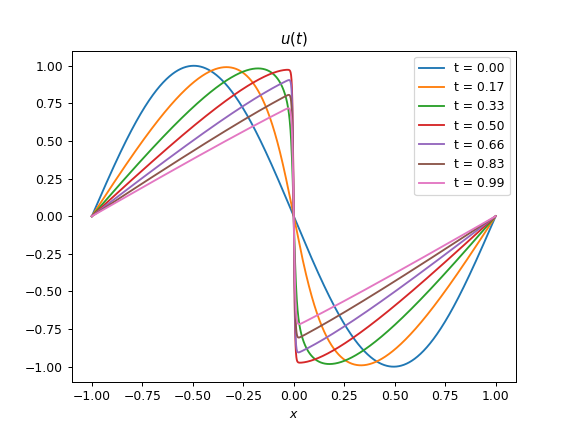

0 / 200
20 / 200
40 / 200
60 / 200
80 / 200
100 / 200
120 / 200
140 / 200
160 / 200
180 / 200

Took 6.40 seconds.


In [5]:
# time stepping
#####################################

(t, T) = (0.0, 1.0)
(n, N) = (0, int(round(T/dt, 0)))

file = File(output + 'data/burgers.pvd')
plt.figure(1)
plt.title("$u(t)$")
plt.xlabel("$x$")
labels = []

sol = {}
sol['x'] = dofs[asc_order]
sol['t'] = np.zeros((N,1))
sol['u'] = np.zeros((len(sol['x']), len(sol['t'])))

t0 = perf_counter()
while n < N:

    # solve variational problem
    solve(F == 0, u, bc)
    
    # save output
    sol['t'][n] = t
    sol['u'][:,n] = u.vector()[asc_order]
    
    # update previous solution
    u_n.assign(u)
    # file << (u, t)
    
    # plot 6 solution snapshots
    if n % round(N/6,0) == 0:
        plt.plot(dofs[asc_order], u.vector()[asc_order])
        labels.append(f"t = {t/T:.2f}")
    
    # print progress
    if n % round(N/10,0) == 0:
        print(f"{n} / {N}")
        
    # update time
    t += dt
    n += 1

tf = perf_counter()
print(f"\nTook {tf-t0:.2f} seconds.")

scipy.io.savemat(output + 'burgers.mat', sol)

plt.legend(labels, loc='upper right')
plt.show()
plt.savefig(output + 'burgers.png')

In [6]:
def snapshot(i):
    plt.clf()
    plt.plot(sol['x'], sol['u'][:,i],'b-',linewidth=3)       
    plt.rc('xtick',labelsize=12)
    plt.rc('ytick',labelsize=12)
    plt.ylim([-1.05, 1.05])
    plt.xlabel('$x$',fontsize='x-large')
    plt.ylabel('$u(t,x)$',fontsize='x-large')
    plt.title('Burgers')

<IPython.core.display.Javascript object>


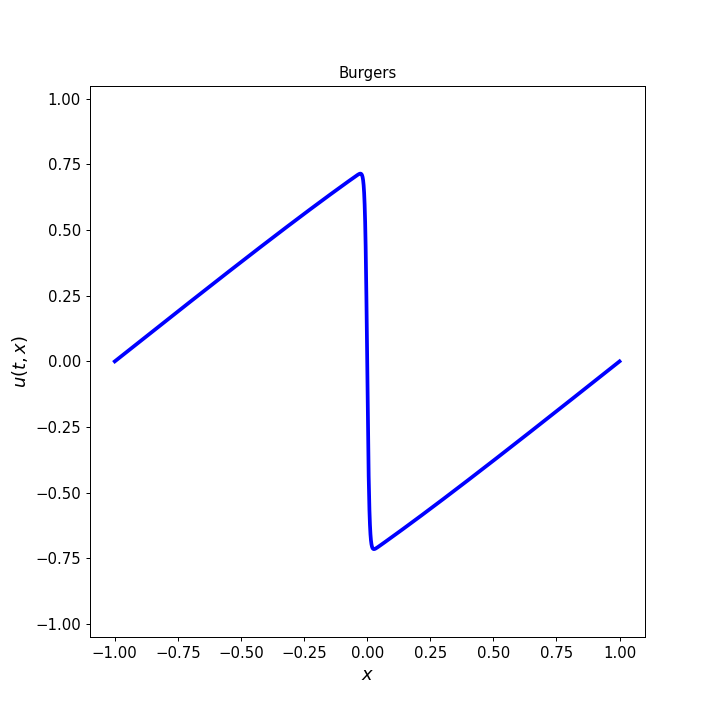

In [7]:
fig = plt.figure(figsize=(8,8), dpi=100)
anim = animation.FuncAnimation(fig,snapshot,frames=N)
anim.save(output + 'burgers.mp4',fps=N/10)